In [1]:
"""The pk2Comp object is a two compartment PK model
    that outputs graphs of concentration of tracer over time.
"""
#!/usr/bin/env python
# coding: utf-8

# In[1]:
import pathlib
import os
import csv
import re
import math
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.optimize import fmin
# %matplotlib inline
# np.set_printoptions(threshold=sys.maxsize)


class pk_two_comp:
    """The pk2Comp object is a two compartment PK model
    that outputs graphs of concentration of tracer over time.
    """

    def __init__(self, wd=pathlib.Path('Data').absolute(), filename='CTPERF005_stress.csv'):
        """Initializes the model with default parameter values for flow, Vp, Visf, and PS.
        Parameters
        ----------
        time : double[]
            list of all timepoints
        aorta : double[]
            concentration of tracer in aorta (input function)
        myo : double[]
            concentration of tracer in myocardial tissue (conc_isf)

        Flow : double
            Flow is the flow of plasma through the blood vessel in mL/(mL*min). Defaults to 1/60.

        Vp : double
            Vp is the volume of plasma in mL. Defaults to 0.05.

        Visf : double
            Visf is the volume of interstitial fluid in mL. Defaults to 0.15.

        PS : double
            PS is the permeability-surface area constant in mL/(g*min). Defaults to 1/60.
        """
        # Subject Data
        if os.path.basename(os.path.normpath(pathlib.Path().absolute())) != 'Data':
            self.wd = pathlib.Path('Data').absolute()
        else:
            self.wd = wd

        self.filename = filename
        self.time = []
        self.aorta = []
        self.myo = []

        # Declare Variables for initial conditions
        # Compartment variables to be fitted
        self.flow = 1/60
        self.visf = 0.15
        self.baseline = 60

        # Other Compartmental Modelvariables
        self.perm_surf = 0.35
        self.vol_plasma = 0.10

        # Solved ode
        self.sol = []

        # Gamma variables
        self.ymax = 250
        self.tmax = 6.5
        self.alpha = 2.5
        self.delay = 0

        self.deriv_sol = np.array([])
        self.fit_myo = np.array([])

    def Get_data(self, filename):
        """Imports data from all .csv files in directory.
        Parameters
        ----------
        wd : str
            wd is the working directory path

        Attributes
        ----------
        time : double[]
            list of all timepoints
        aorta : double[]
            concentration of tracer in aorta (input function)
        myo : double[]
            concentration of tracer in myocardial tissue (conc_isf)

        Returns
        -------
        time : double[]
            list of all timepoints
        aorta : double[]
            concentration of tracer in aorta (input function)
        myo : double[]
            concentration of tracer in myocardial tissue (conc_isf)
        """
        os.chdir(self.wd)
        # File not found error
        if not os.path.isfile(filename):
            raise ValueError(
                "Input file does not exist: {0}. I'll quit now.".format(filename))

        data = list(csv.reader(open(filename), delimiter='\t'))

        for i in range(12):
            self.time.append(
                float(re.compile('\d+[.]+\d+|\d+').findall(data[i+1][0])[0]))
            self.aorta.append(
                float(re.compile('\d+[.]+\d+|\d+').findall(data[i+1][1])[0]))
            self.myo.append(
                float(re.compile('\d+[.]+\d+|\d+').findall(data[i+1][2])[0]))

        return self.time, self.aorta, self.myo

    # gamma_var distribution curve
    def gamma_var(self, time=np.arange(0, 25), ymax=10, tmax=10, alpha=2, delay=0):
        """Creates a gamma variate probability density function with given alpha,
        location, and scale values.
        Parameters
        ----------
        t : double[]
            array of timepoints
        ymax : double
            peak y value of gamma distribution
        tmax : double
            location of 50th percentile of function
        alpha : double
            scale parameter
        delay : double
            time delay of which to start gamma distribution

        Returns
        -------
        y : double[]
            probability density function of your gamma variate.
        """
        # Following Madsen 1992 simplified parameterization for gamma variate
        t = time
        self.ymax = ymax
        self.tmax = tmax
        self.alpha = alpha
        self.delay = delay

        y = np.zeros(np.size(t))  # preallocate output

        # For odeint, checks if t input is array or float
        if isinstance(t, (list, np.ndarray)):
            for i in range(np.size(y)):
                if t[i] < delay:
                    y[i] = 0
                else:
                    y[i] = round((ymax*tmax**(-alpha)*math.exp(alpha))*(t[i]-delay)
                                 ** alpha*math.exp(-alpha*(t[i]-delay)/tmax), 3)
            return y

        else:
            y = round((ymax*tmax**(-alpha)*math.exp(alpha))*(t-delay)
                      ** alpha*math.exp(-alpha*(t-delay)/tmax), 3)
            return y

    # gamma_var_error
    def inputMSE(self, guess=[10, 10, 2, 5]):
        """Calculates Mean squared error (MSE) between data and
        gamma variate with given parameters values.
        Parameters
        ----------
        param : ndarray[]
            time : double[]
                array of timepoints
            ymax : double
                peak y value of gamma distribution
            tmax : double
                location of 50th percentile of function
            alpha : double
                scale parameter
            delay : double
                time delay of which to start gamma distribution

        Returns
        -------
        MSE : double
            Mean squared error
        """
        if len(guess) < 1:
            self.ymax = 10
            self.tmax = 10
            self.alpha = 2
            self.delay = 5
        elif len(guess) < 2:
            self.ymax = guess[0]
            self.tmax = 10
            self.alpha = 2
            self.delay = 5
        elif len(guess) < 3:
            self.ymax = guess[0]
            self.tmax = guess[1]
            self.alpha = 2
            self.delay = 5
        elif len(guess) < 4:
            self.ymax = guess[0]
            self.tmax = guess[1]
            self.alpha = guess[2]
            self.delay = 5
        else:
            # Mean squared error (MSE) between data and gamma variate with given parameters
            self.ymax = guess[0]
            self.tmax = guess[1]
            self.alpha = guess[2]
            self.delay = guess[3]

        mse = 0

        if self.tmax <= 0 or self.ymax <= 10 or self.delay < 0 or self.alpha < 0 \
                or self.alpha > 1000 or self.tmax > 1000:
            mse = 1000000  # just return a big number

        else:
            model_vals = self.gamma_var(
                self.time, self.ymax, self.tmax, self.alpha, self.delay)

            for i in range(len(self.aorta)):
                mse = (self.aorta[i] - model_vals[i])**2 + mse
            mse = mse / len(self.aorta)
        return round(mse, 3)

    def inputFuncFit(self, initGuesses):
        """Uses fmin algorithm (Nelder-Mead simplex algorithm) to
        minimize loss function (MSE) of input function.
        Parameters
        ----------
        initGuesses : ndarray[]
            Array of initial guesses containing:
                time : double[]
                    array of timepoints
                ymax : double
                    peak y value of gamma distribution
                tmax : double
                    location of 50th percentile of function
                alpha : double
                    scale parameter
                delay : double
                    time delay of which to start gamma distribution
        Returns
        -------
        opt : double[]
            optimized parameters
        """
        # Mean squared error (MSE) between data and gamma variate with given parameters
        opt = fmin(self.inputMSE, initGuesses, maxiter=1000)

        self.ymax = opt[0]
        self.tmax = opt[1]
        self.alpha = opt[2]
        self.delay = opt[3]

        return opt.round(2)

    # Derivative function
    def derivs(self, time, curr_vals):
        """Finds derivatives of ODEs.

        Parameters
        ----------
        curr_vals : double[]
            curr_vals it he current values of the variables we wish to
            "update" from the curr_vals list.

        time : double[]
            time is our time array from 0 to tmax with timestep dt.

        Returns
        -------
        dconc_plasma_dt : double[]
            contains the derivative of concentration in plasma with respect to time.
        dconc_isf_dt : double[]
            contains the derivative of concentration in interstitial fluid with respect to time.
        """
        # Unpack the current values of the variables we wish to "update" from the curr_vals list
        conc_plasma, conc_isf = curr_vals

        # Define value of input function conc_in
        conc_in = self.gamma_var(time, self.ymax, self.tmax,\
                                 self.alpha, self.delay)

        # Right-hand side of odes, which are used to computer the derivative
        dconc_plasma_dt = (self.flow/self.vol_plasma)*(conc_in - conc_plasma) \
        + (self.perm_surf/self.vol_plasma)*(conc_isf - conc_plasma)
        dconc_isf_dt = (self.perm_surf/self.visf)*(conc_plasma - conc_isf)
        return dconc_plasma_dt, dconc_isf_dt

    def outputMSE(self, guess):
        """Calculates Mean squared error (MSE) between data and
        gamma variate with given parameters values.
        Parameters
        ----------
        guess : ndarray[]

            Flow : double
                Flow is the flow of plasma through the blood vessel in mL/(mL*min).
                Defaults to 1/60.

            Vp : double
                Vp is the volume of plasma in mL. Defaults to 0.05.

            Visf : double
                Visf is the volume of interstitial fluid in mL. Defaults to 0.15.

            PS : double
                PS is the permeability-surface area constant in mL/(g*min). Defaults to 1/60.
        Returns
        -------
        MSE : double
            Mean squared error
        """
        self.flow = guess[0]
        self.visf = guess[1]
        self.baseline = guess[2]

        mse = 0

        if self.flow <= 0 or self.flow >= 25 or self.visf > 100 or self.visf < 0 \
                or self.baseline > 150 or self.baseline < 0:
            mse = 100000  # just return a big number

        else:
            sol = solve_ivp(self.derivs, [0, 30], [0, 0], t_eval=self.time)
            MBF = sol.y[0] + sol.y[1]

            temp = np.asarray(self.myo) - self.baseline

            for i in range(len(self.myo)):
                mse = (temp[i] - MBF[i])**2 + mse

            mse = mse / len(self.myo)
        return mse

    def outputFuncFit(self, initGuesses):
        """Uses fmin algorithm (Nelder-Mead simplex algorithm) to minimize
        loss function (MSE) of input function.
        Parameters
        ----------
        initGuesses : ndarray[]
            Array of initial guesses containing:
                time : double[]
                    array of timepoints
                ymax : double
                    peak y value of gamma distribution
                tmax : double
                    location of 50th percentile of function
                alpha : double
                    scale parameter
                delay : double
                    time delay of which to start gamma distribution
        Returns
        -------
        opt : double[]
            optimized parameters
        """
        # Mean squared error (MSE) between data and gamma variate with given parameters
        opt1 = fmin(self.outputMSE, initGuesses, maxiter=10000)

        self.flow = opt1[0]
        self.visf = opt1[1]
        self.baseline = opt1[2]

        return opt1.round(4)

    def main(self):

        # Gets data from file
        self.Get_data(self.filename)

        # Plots original data
        plt.plot(self.time, self.aorta, 'bo')
        plt.plot(self.time, self.myo, 'ro')

        # Fit gamma_var input function and plots it
        opt = self.inputFuncFit([250, 7, 4, 0])
        plt.plot(np.arange(0, 25, 0.01), self.gamma_var(np.arange(0, 25, 0.01),
                                                        opt[0], opt[1], opt[2], opt[3]), 'k-')

        # Fit uptake function and plot it
        opt2 = self.outputFuncFit([.011418, .62, self.myo[0]])
        self.deriv_sol = solve_ivp(self.derivs, [0, 30], [0, 0], t_eval=self.time)
        self.fit_myo = self.deriv_sol.y[0] + self.deriv_sol.y[1]
        plt.plot(self.time, self.fit_myo + self.baseline, 'm-')

Optimization terminated successfully.
         Current function value: 225.048000
         Iterations: 82
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: 17.715727
         Iterations: 153
         Function evaluations: 342


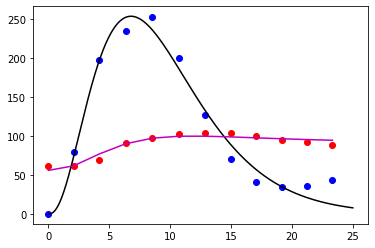

In [2]:
pk = pk_two_comp()
pk.main()

Optimization terminated successfully.
         Current function value: 127.579000
         Iterations: 123
         Function evaluations: 246
Optimization terminated successfully.
         Current function value: 8.080500
         Iterations: 88
         Function evaluations: 197


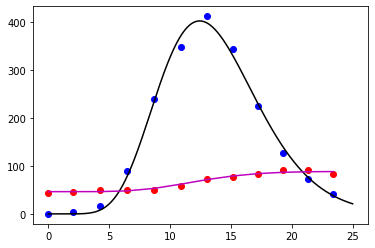

In [3]:
pk1 = pk_two_comp(filename = 'CTPERF005_rest.csv')
pk1.main()

In [4]:
pk2 = pk_two_comp(filename = 'CTPERF006_rest.csv')
pk2.main()

Optimization terminated successfully.
         Current function value: 66.216000
         Iterations: 136
         Function evaluations: 281
Optimization terminated successfully.
         Current function value: 7.342903
         Iterations: 126
         Function evaluations: 243


Optimization terminated successfully.
         Current function value: 109.357000
         Iterations: 110
         Function evaluations: 225
Optimization terminated successfully.
         Current function value: 7.649120
         Iterations: 123
         Function evaluations: 277


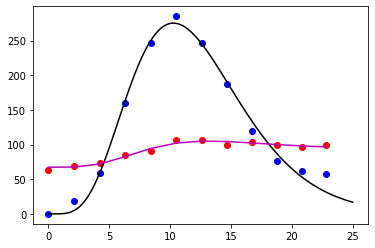

In [11]:
pk3 = pk_two_comp(filename = 'CTPERF006_stress.csv')
pk3.main()